This is a notebook with various methods for processing the Nino 3.4, PDO and AMO time series found on NOAA websites into useable data

In [1]:
import os
import datetime as dt
import matplotlib.pyplot as plt
import csv
import pickle

In [2]:
filepath = r'C:\Users\bpara\Geo data\climate oscillations'
amo_s_psl_p = os.path.join(filepath, "amo smoothed.txt")
amo_r_psl_p = os.path.join(filepath, "amo raw.txt")
nino_r_psl_p = os.path.join(filepath, "nino raw data.txt")
pdo_r_csv_p = os.path.join(filepath, "pdo raw.csv")
pna_r_psl_p = os.path.join(filepath, "pna raw.txt")

In [5]:
os.listdir(filepath)

['amo raw.txt',
 'AMO series',
 'amo smoothed.txt',
 'Minihw 7.txt',
 'nino raw data.txt',
 'Nino series',
 'pdo raw.csv',
 'PDO series',
 'pna raw.txt']

In [6]:
#This is a function that imports standard psl format data when it is copy-pasted into a .txt file, for points with no data, a value of None is inserted at that index

def import_psl_format(filepath, start_year, end_year, datakey):
    raw_text = open(filepath, "r")
    final_data = dict()
    final_data["time"] = []
    final_data[datakey] = []
    
    for x in raw_text:
        year_data = x.split()[1:]
        month = 1
        current_year = int(x.split()[0])
        if current_year < start_year or current_year > end_year: 
            continue #This is a bit hack-y, but it's a fast way of doing this
        for val in year_data:
            final_data["time"].append(dt.datetime(current_year, month, 1))
            if float(val) != -99.990:
                final_data[datakey].append(float(val))
            else:
                final_data[datakey].append(None)
            month += 1
    
    
    raw_text.close()
    
    return final_data

In [7]:
#This is a function that imports data in a CSV in the NOAA format (or at least the format of the one CSV file I got from NOAA, which I hope is standard)

def import_csv_format(filepath, start_year, end_year, datakey):
    final_data = dict()
    final_data["time"] = []
    final_data[datakey] = []
    
    with open(filepath, newline = '') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        n = 0
        for row in csvreader:
            if n < 2:
                n +=1 #This is again, kind of hack-y, but seems to be the best way to ignore the first 2 rows since csvreaders are not indexable
                continue
            year = int(row[0][0:4])
            month = int(row[0][4:6])
            if year < start_year or year > end_year:
                continue
            final_data["time"].append(dt.datetime(year, month, 1))
            final_data[datakey].append(float(row[1]))
        
    return final_data

In [8]:
#This function takes your dataset and returns a smoothed dataset generated by averaging each month with the n previous months and n upcoming months (so like a 3-month rolling
#average would be made with n=1)

def n_month_average(data, datakey, months):
    final_data = dict()
    final_data["time"] = []
    final_data[datakey] = []
    
    for x in range(len(data["time"])):
        if x - months > 0 and x + months + 1 < len(data["time"]) - 1:
            average_vals = data[datakey][x - months : x + months + 1]
            total = 0
            for val in average_vals:
                if val == None:
                    total = None
                    break
                total += val
            if total == None:
                final_data["time"].append(data["time"][x])
                final_data[datakey].append(None)
                continue
            final_data["time"].append(data["time"][x])
            final_data[datakey].append(total / (2 * months + 1))
            
    return final_data

In [9]:
#This is a function that takes in the raw nino data, and for each time interval, it finds the number of nino/nina local maxima/minima with a magnitude of >0.5 in a given
#amount of months before or after each date. Th

def smooth_nino_data(data, months):
        final_data = dict()
        final_data["time"] = []
        final_data["nino"] = []
        final_data["nina"] = []
        
        for date in range(len(data["time"])):
            nino_found = 0
            nina_found = 0
            if date - months < 0 or date + months + 1 > len(data["time"]) - 1:
                continue
            
            vals_to_check = data["nino"][date - months : date + months + 1]
            
            for val in range(len(vals_to_check)):
                #This whole mess is just looking for extrema
                if val == 0:
                    if vals_to_check[val] >= 0.5:
                        nino_found +=1
                    if vals_to_check[val] <= -0.5:
                        nina_found +=1                    
                else:
                    if vals_to_check[val] >= 0.5 and vals_to_check[val - 1] < 0.5:
                        nino_found +=1
                    if vals_to_check[val] <= -0.5 and vals_to_check[val - 1] > -0.5:
                        nina_found +=1
            
            final_data["time"].append(data["time"][date])
            final_data["nino"].append(nino_found)
            final_data["nina"].append(nina_found)
        
        return final_data

In [11]:
amo_s = import_psl_format(amo_s_psl_p, 1980, 2019, "amo")
nino_r = import_psl_format(nino_r_psl_p, 1980, 2019, "nino")
pdo_r = import_csv_format(pdo_r_csv_p, 1975, 2020, "pdo")
pna_r = import_psl_format(pna_r_psl_p, 1980, 2019, "npa")

In [12]:
pdo_s = n_month_average(pdo_r, "pdo", 60)
nino_s = n_month_average(nino_r, "nino", 4)
nino_s_2 = smooth_nino_data(nino_r, 60)
pna_s = n_month_average(pna_r, "npa", 60)

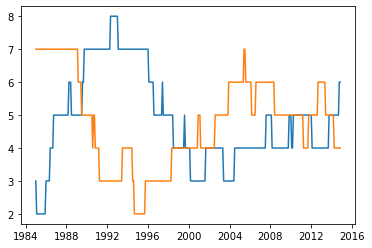

In [11]:
plt.plot(nino_s_2["time"], nino_s_2["nino"])
plt.plot(nino_s_2["time"], nino_s_2["nina"])

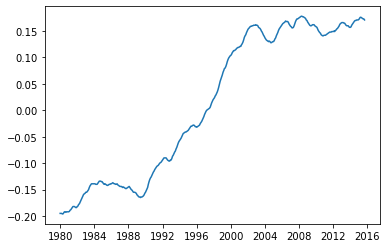

In [14]:
plt.plot(amo_s["time"], amo_s["amo"])
#plt.plot(nino_s["time"], nino_s["nino"])

In [12]:
file1 = open("Nino series", "wb")
pickle.dump(nino_s_2, file1)
file1.close()

file2 = open("PDO series", "wb")
pickle.dump(pdo_s, file2)
file2.close()

file3 = open("AMO series", "wb")
pickle.dump(amo_s, file3)
file3.close()



In [13]:
file4 = open("PNA series", "wb")
pickle.dump(pna_s, file4)
file4.close()